# Gaia CMD

In [9]:
import matplotlib.pyplot as plt
import numpy as np

from astropy.table import QTable
from astropy import units as u
from astropy.coordinates import SkyCoord

from astroplan import FixedTarget
from astroplan.plots import plot_finder_image
from matplotlib.patches import Rectangle, Circle, Ellipse, Polygon

from astroquery.gaia import Gaia
from astropy.io import ascii
import warnings
warnings.filterwarnings("ignore", category = UserWarning)

---
# Instructions

The goal of this assignment is to demonstrate your python skills in making a color-magnitude diagram from Gaia data.

This ideas and techniques used in this assignment can be found in the `Python_Plotting_Annotate` notebook

Your first step is to pick a point in space **far from the galacitic plane** (the blue regions in the plot below). The reason for
this is that we want to pick a region that has little gas and dust. This gas and dust effects the colors of observed object making
them appear more red. We want to avoid this reddening.

### Pick and RA and a DEC far away from the galactic plane.

&nbsp;

<p>
<img src="./images/GalCoords.jpg" width = "1000">
</p>

### Enter the coordinates of the center of your field

- Replace the **XXX** with your coordinates

In [3]:
my_object_ra = 16 * u.hourangle
my_object_dec = 30 * u.deg

### Use `FixedTarget` from `astroplan` to get setup a target object. Make sure to give it a name.

- #### `FixedTarget(coord = SkyCoord(ra = my_object_ra, dec = my_object_dec), name = NAME)`

In [4]:
target = FixedTarget(coord = SkyCoord(ra = my_object_ra, dec = my_object_dec), name = 'Boo')
target

<FixedTarget "Boo" at SkyCoord (ICRS): (ra, dec) in deg (240., 30.)>

### Use `plot_finder_image` to get get an image of your field from the [ESO Online Digitized Sky Survey](http://archive.eso.org/dss/dss).

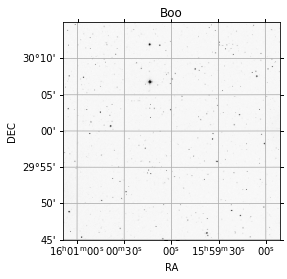

In [5]:
image = plot_finder_image(target, fov_radius = 0.5 * u.deg)

## Get the the [Gaia data](https://www.cosmos.esa.int/web/gaia/dr3) for your field

- Get the data for the 3,000 (at most) **nearest** stars.
- They should all be within **0.5 degress** of your target coordinates.
- You will want the columns: `source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax`

In [6]:
query = f"""
SELECT TOP 3000
source_id, ra, dec, phot_g_mean_mag, bp_rp, parallax
FROM gaiadr3.gaia_source_lite
WHERE CONTAINS(
   POINT('ICRS', {target.ra.degree}, {target.dec.degree}),
   CIRCLE('ICRS', ra, dec, 0.5)
   ) = 1
AND bp_rp IS NOT NULL
AND parallax IS NOT NULL
AND parallax > 0.1
ORDER BY parallax ASC
"""

#I ended up with some of the parallaxes being less than 0. I looked into it and found a paper by Luri et al that detailed why this was, and I also found a JupyterNotebook by Anthony Brown that detailed how to properly remove this issue
#It ended up being a bit more than I was capable of doing as I started this over the weekend so instead I just ignored any parallax less than 0 and used that instead. I am aware this biases the data but I am incapable of fixing it on the current timeframe


In [7]:
HRJob = Gaia.launch_job(query)

In [11]:
HRqtable = HRJob.get_results()
HRqtable
ascii.write(HRqtable[0:5], format='latex')

\begin{table}
\begin{tabular}{cccccc}
source_id & ra & dec & phot_g_mean_mag & bp_rp & parallax \\
 & $\mathrm{{}^{\circ}}$ & $\mathrm{{}^{\circ}}$ & $\mathrm{mag}$ & $\mathrm{mag}$ & $\mathrm{mas}$ \\
1320545419515924608 & 240.3294214170087 & 30.155194602960755 & 19.978693 & 0.54857254 & 0.10028244241111633 \\
1320466495196857344 & 239.98079049880977 & 30.176290521857148 & 20.621374 & 0.74910545 & 0.10031050670754565 \\
1320523948976212096 & 239.59862508789516 & 30.274987075868427 & 17.592302 & 0.87584305 & 0.10047660606216752 \\
1320545728753578112 & 240.3051336355821 & 30.183353208892694 & 17.961245 & 0.80218124 & 0.10138319241294069 \\
1320434231403278592 & 239.74535642431212 & 29.979977638900053 & 19.395845 & 1.420145 & 0.10148559890526335 \\
\end{tabular}
\end{table}


### Use `parallax` and `phot_g_mean_mag` to get **distance** (in pc) and the **absolute magnitude** ($G_{M}$)

- Add them as columns to the data table

In [8]:
def absMag(mag, distance):
    result =  mag - 5 * np.log10(distance / (10 * u.parsec)) * u.mag
    return result
def mag2Lum(mag):
    

In [9]:
parallax = HRqtable['parallax']
mag = HRqtable['phot_g_mean_mag']
distance = HRqtable['parallax'].to(u.parsec, equivalencies=u.parallax())
bigGM = absMag(mag, distance)

In [10]:
HRqtable['Distance'] = distance
HRqtable['Gm'] = bigGM

In [11]:
HRqtable

source_id,ra,dec,phot_g_mean_mag,bp_rp,parallax,Distance,Gm
,deg,deg,mag,mag,mas,pc,
int64,float64,float64,float32,float32,float64,float64,float64
1320545419515924608,240.3294214170087,30.155194602960755,19.978693,0.54857254,0.10028244241111633,9971.83530792375,4.984817522406255
1320466495196857344,239.98079049880977,30.176290521857148,20.621374,0.74910545,0.10031050670754565,9969.045445214333,5.6281062512899425
1320523948976212096,239.59862508789516,30.274987075868427,17.592302,0.87584305,0.10047660606216752,9952.565469630548,2.6026271067534577
1320545728753578112,240.3051336355821,30.183353208892694,17.961245,0.80218124,0.10138319241294069,9863.56787747353,2.991074395229809
1320434231403278592,239.74535642431212,29.979977638900053,19.395845,1.420145,0.10148559890526335,9853.614806308611,4.427867508212339
1320498312315466240,239.52435940091698,30.132575193278992,18.28773,0.9575577,0.10220683652591914,9784.081319710986,3.335128995047704
1320256454117013120,240.4420145673185,29.866151264228936,20.672823,1.5979347,0.1022999637893532,9775.174525565904,5.722200352205361
1320506391149899392,239.7476280039802,30.110546223531507,17.226952,0.87379265,0.10261651238013914,9745.020336449716,2.2830378502989284


---

# Make an annotated color magnitude diagram (BP-RP vs. $G_{M}$) of your field.

### Minimum requirements for 12 points:

- A figure size of 15 in x 15 in
- Both axes labeled
- A title for the figure
- The main sequence indicated in some way
- A symbol and label placed at the position of the Sun (**BP-RP** = 0.82, $G_{M}$ = 4.67)

### You can earn more points by adding more information and annotations.

- Take a look at the file `GaiaInfo.pdf` in your Info directory. The Gaia CMD on the back is a good source of ideas.
- The Chapter - *The Classification of Stellar Spectra* from Carroll and Ostlie (BOB) is another good place to look.
- All of Astro 322 is fair game.
- Figuring out and labeling non-stellar objects will bring in the points
  - These objects will have anomalous values of **BP-RP** and $G_{M}$ 

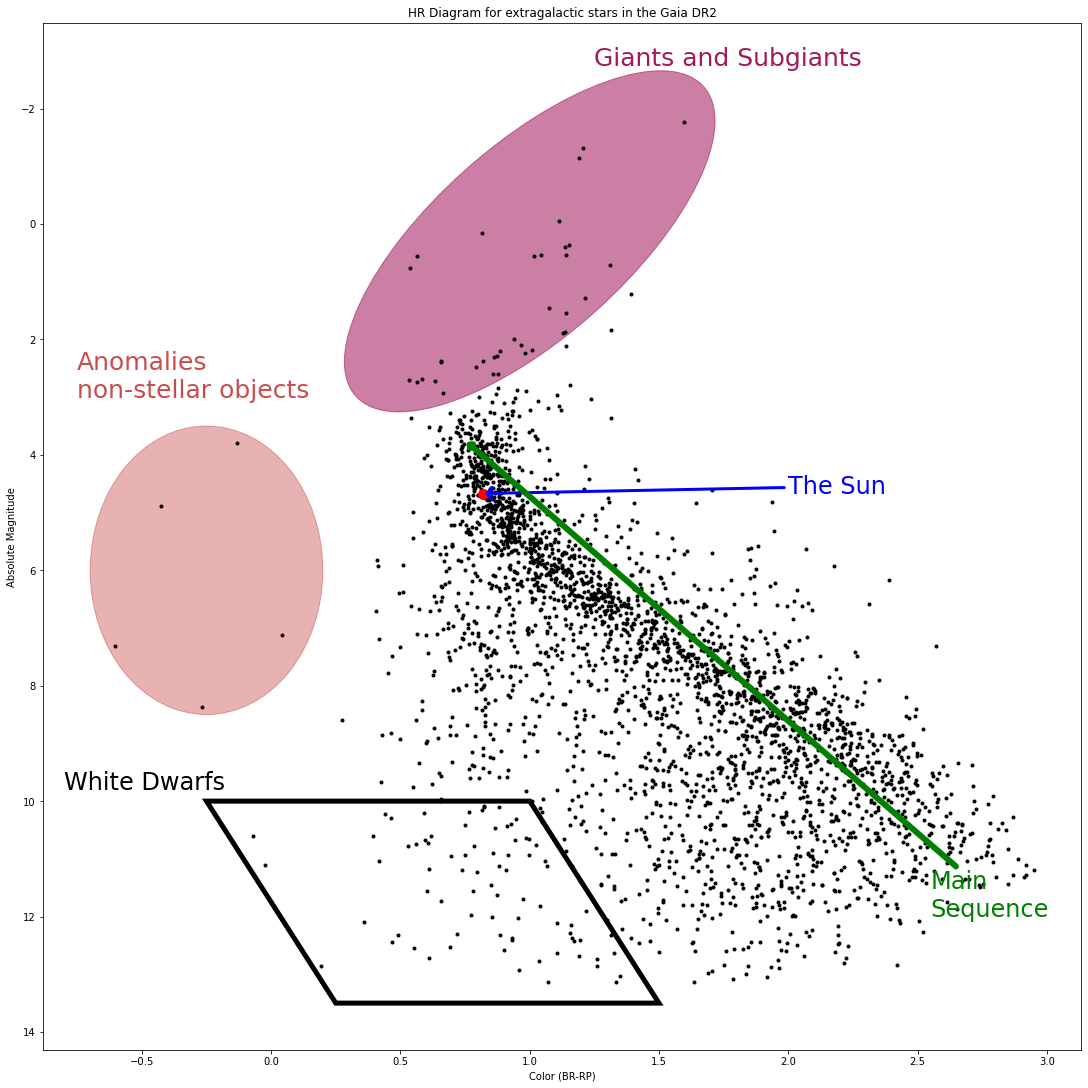

In [12]:
fig, ax = plt.subplots(
    figsize = (15, 15),
    constrained_layout = True
)
x = HRqtable['bp_rp']
y = HRqtable['Gm']
ax1.set_xlabel('Color (BR-RP)')
ax1.set_ylabel('Absolute Magnitude')
ax.set_title('HR Diagram for extragalactic stars in the Gaia DR2')

ax.invert_yaxis()
ax.plot(x, y,
       color = 'k',
       marker = 'o',
       linestyle = 'None',
        markersize = 3
       )

#Annotating the sun
ax.annotate('The Sun',
            fontsize = 24,
            color = 'blue',
            xy = (0.82,  4.67),
            xytext = (2, 4.67),
            arrowprops = {'color':'blue',
                          'linewidth':3,
                          'arrowstyle':'->, head_length = 0.2,head_width=0.25'}
           )
#Where the main sequence follows
ax.annotate('Main\nSequence',
            fontsize = 24,
            color = 'green',
            xy = (0.75, 3.75),
            xytext = (2.55,12),
            arrowprops = {'color':'green',
                          'linewidth':6,
                          'arrowstyle':'-|>, head_length = 0.1, head_width=0.1'}
           )
#A point at the Sun's location on this diagram
ax.plot(0.82,4.67,
        color = 'r',
        marker = 'o',
       markersize = 10)

#Indicating oddities
anomaly = Ellipse((-0.25,6),
                  width = 0.9,
                  height = 5,
                  color = (0.7,0,0,0.3))
ax.add_patch(anomaly)
ax.text(-0.75, 3,
        'Anomalies\nnon-stellar objects',
        color = (0.7,0,0,0.7),
        fontsize = 25)

#Indicating Red Giants
redGiants = Ellipse((1,0.3),
                   width = 1,
                   height = 6,
                   angle = 10,
                   color = (0.6, 0.0, 0.3, 0.5))
ax.add_patch(redGiants)
ax.text(1.25, -2.75, 'Giants and Subgiants', color = (0.6,0.0,0.3,0.9), fontsize = 25)

#Indicating White Dwarves
whiteDwarf = np.array( ((-0.25,10),(1,10),(1.5,13.5),(0.25,13.5)))
dwarfPatch = Polygon(whiteDwarf,
                     facecolor = 'white',
                     edgecolor = 'black',
                     linewidth = 5)
ax.add_patch(dwarfPatch)
ax.text(-0.8, 9.8, 'White Dwarfs', fontsize = 24);

---

### Save and download a PNG version of your figure. You will need this for the final assignment of the class.

- Feel free to change the name of the file if you wish.

In [14]:
fig.savefig('HR1.png', bbox_inches='tight')

### Due Mon Nov 28  - 1 pm
- `File -> Download as -> HTML (.html)`
- `upload your .html file to the class Canvas page`